# Short-Time Fourier Transform : éléments d'analyse spectrale

## Introduction à 4 petits exercices


L'objectif de ces petits exercices est d'explorer les caractéristiques des fenêtres d'analyse fréquentielles utilisées pour faire la STFT, appliquée à la musique.  Ces exercices se feront en deux parties principales :
<LI> Une exploration des caractérisiques des fenêtres d'analyse : extraction du lobe principal, de son amplitude et du rapport Signal/Bruit après reconstruction du signal.</LI>

<li> Calcul de l'énergie d'un signal dans des bandes de fréquence données, et éventuellement détection de rythme</LI>

# Quelques rappels

## Largeur du lobe principal et atténuation du lobe secondaire d'une fenêtre d'analyse

La largeur du lobe principal est un élément fondamental de la fenêtre d'analyse.  En effet, une sinusoïde complexe de fréquence $\frac{k}{N}$, avec $k$ entier et de longueur $N$, a comme spectre $X[k] = \delta[k]$.  Après fenêtrage (donc multiplication dans le domaine temporel), par une fenêtre de longueur $M<N$, l'impulsion $\delta[k]$ sera convoluée par la réponse fréquentielle $W[k]$, et apparaîtra donc comme étant "élargie" en fréquence. De ce point de vue, on a intérêt à utiliser une fenêtre de largeur la plus petite possible.

Par contre, $W[k]$ comprend également des lobes secondaires, qui doivent avoir l'amplitude (relative à celle du lobe principal) la plus faible possible, et les fenêtres de lobe principal le plus étroit ont également un lobe secondaire d'amplitude plus élevée.  Il faut donc faire un compromis entre largeur de bande du lobe principal et atténuation du lobe secondaire.

Vous vérifierez que si $M$ est fixé, la largeur du lobe principal n'est pas modifiée.  Par contre, vous verrez sur l'exemple ci-dessous que, si on modifie la quantité de zéro padding (ici on utilise $N = 8*M$), la largeur du lobe principal est (ici 8 fois) plus grande.

##  FFT
On utilise la FFT comme méthode rapide de calcul de la DFT.  La FFT est la plus efficace quand $N$ est une puissance de 2.  Notez, toujours dans l'exemple ci-dessous, l'utilisation de "fftshift" pour centrer le spectre autour de la fréquence 0.

## Energie d'un signal

L'énergie d'un signal $x[n]$ de longueur $N$ peut-être calculée, dans le domaine temporel par 
$$ E = \displaystyle \sum_{n=0}^{N-1} \left|x[n]\right|^2$$


## Energie dans une bande fréquentielle

L'énergie dans une bande fréquentielle entre les indices $k_1$ et $k_2$ peut être calculée par 

$$E = \displaystyle \frac{1}{N}\sum_{k=k_1}^{k_2} \left|X[k]\right|^2$$

On notera la présence du facteur $\frac{1}{N}$, qui tient compte de la "non orthonormalité" de la DFT.

Attention, l'énergie (en dB) se calcule par :

$$ E_{dB} = 10 \log_{10}(E)$$

Alors que l'amplitude en dB se calcule par :

$$ A_{dB} = 20 \log_{10}(A)$$

En effet, une énergie est proportionnelle à une amplitude au carré, et les décibels représentes une mesure d'énergie, ou de puissance, ou un rapport entre ces quantités.

## Rapport signal/bruit (SNR : Signal to Noise Ratio)

Soit un signal $v$ définit par $v=x+n$, où $x$ est "le signal" et $n$ le bruit.

Le rapport signal/bruit est le rapport entre la puissance (ou l'énergie) du signal et la puissance (ou l'énergie) du bruit, la plupart du temps exprimée en dB.

$$SNR = 10 \log_{10} \left(\frac{E_{signal}}{E_{bruit}}\right)$$



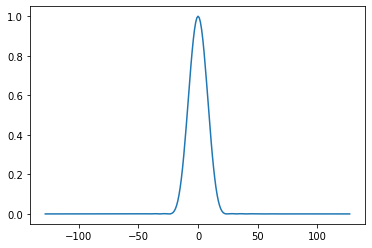

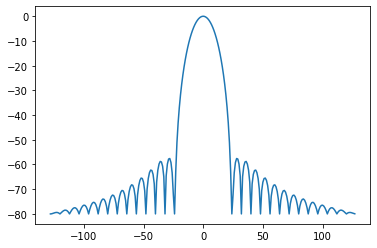

9.7472
9.7472


In [8]:
import numpy as np
from scipy.signal import get_window
from scipy.fftpack import ifft,fft, fftshift
import math
import matplotlib.pyplot as plt
eps = np.finfo(float).eps

M=32;
N=8*M;
w=get_window('blackman',M)
w=np.concatenate([w,np.zeros(N-M)])
f=np.arange(-N/2,N/2,1)
W=fft(w)
Wor=W
W=W/np.max(abs(W))
plt.plot(f,abs(fftshift(W)))
plt.show()
plt.plot(f,20*np.log10(abs(fftshift(W))+1e-4))
plt.show()
print(np.sum(w**2))
print(np.sum(abs(Wor)**2)/N)


## exo 1 : extraire le lobe principal d'une fenêtre d'analyse

Compléter la fonction $extractMainLobe(window,M)$ qui extrait le lobe principal de l'amplitude du spectre.  Vous utiliserez du zéropadding d'ordre 8 ($N=8*M$).  Les entrées de la fonction sont le type de fenêtre ($window$) et la taille de la fenêtre ($M$).  La sortie de la fonction est un $np.array$ contenant les valeurs (en dB) des échantillons de la fenêtre principale (en fréquence).  Notez que $\log(0)$ étant indéfini, on utilise souvent $\log(x+eps)$, où $x$ est positif (car un carré) et eps = 1e-16 (voire plus) pour éviter le problème induit quand $x=0$.


Dans un premier temps, vous pouvez "tricher" en détectant visuellement l'endroit où commence et termine la fenêtre.  Dans un deuxième temps, vous pouvez "détecter" les passages par zéro (ou presque !) de la réponse fréquentielle, et ainsi détecter les indices de début et de fin de fenêtre (qui sont les premiers autour de $k=0$ si vous centrer, ou $k=N/2$ si vous ne centrez pas la fenêtre fréquentielle).

<li>Test case 1: Si vous utilisez  $window = 'blackmanharris'$ et $M = 100$, la sortie devrait être un np.array de 65 échantillons.</li>
<li>Test case 2: Si vous utilisez  $window = 'boxcar'$ (fenêtre rectangulaire) et $M = 120$, la sortie devrait être un np.array de 17 échantillons.</li>
<li>Test case 3: Si vous utilisez  $window = 'hamming'$ et $M = 256$, la sortie devrait être un np.array de 33 échantillons.</li>


In [9]:
from array import array
f=np.arange(0,M)

def compute_mainlobe_width(spectrum):
    """
    computes mainlobe width from spectrum
    
    assumes the mainlobe starts at 0, that spectrum size is odd, and that 
    the spectrum is real-valued (half of the frequencies)
    
    returns the number of samples of full mainlobe (not just half)
    """
    abs_spectrum = np.abs(spectrum)
    current_value = abs_spectrum[0]
    for ind, next_value in enumerate(abs_spectrum): 
        if next_value > current_value:                
            break
        else:
            current_value = next_value        
    return 2 * ind - 1

def extractMainLobe(window, M):
    
#    Input:
#            window (string): Window type to be used (Either rectangular ('boxcar'), 'hamming' or '
#                blackmanharris')
#            M (integer): length of the window to be used
#    Output:
#            The function should return a numpy array containing the main lobe of the magnitude 
#            spectrum of the window in decibels (dB).

    ### Your code here
    
    N=8*M;
    w=get_window(window,M)
    w_fft = np.fft.rfft(w, N)
    freqs = np.fft.rfftfreq(n, d=1/m)
    
    nbr=compute_mainlobe_width(w_fft)
    print(nbr)
    
    s = np.abs(w_fft)[:nbr]
    return s

In [41]:

a = extractMainLobe('blackmanharris', 100)
b = extractMainLobe('boxcar', 120)
c = extractMainLobe('hamming', 256)
print('Blackman-Harris with M=100 array =')
print(a)
print(' ')
print('Rectangle with M=120 array =')
print(b)
print(' ')
print('Hamming with M=256 array =')
print(c)

65
17
33
Blackman-Harris with M=100 array =
[3.58750000e+01 3.56633054e+01 3.50350716e+01 3.40105107e+01
 3.26222036e+01 3.09135146e+01 2.89365127e+01 2.67495295e+01
 2.44145000e+01 2.19942459e+01 1.95498549e+01 1.71382996e+01
 1.48104162e+01 1.26093349e+01 1.05694173e+01 8.71572469e+00
 7.06400000e+00 5.62111989e+00 4.38594333e+00 3.35046617e+00
 2.50117937e+00 1.82052636e+00 1.28836003e+00 8.83311483e-01
 5.84000000e-01 3.70033320e-01 2.22769231e-01 1.25830107e-01
 6.53808464e-02 3.01959740e-02 1.15526686e-02 2.99293058e-03
 1.06234487e-15 3.68245157e-04 1.58366750e-04 6.82808284e-04
 8.97082803e-04 7.94604479e-04 5.11879837e-04 2.08216904e-04
 8.38683943e-16 6.52580934e-05 4.35906373e-05 1.66036404e-04
 3.10618667e-04 3.92449144e-04 3.68623296e-04 2.30125434e-04
 2.48491994e-16 2.74947823e-04 5.36642532e-04 7.29312129e-04
 8.11297016e-04 7.62998557e-04 5.89873296e-04 3.20418830e-04
 7.01952365e-16 3.17997003e-04 5.81886667e-04 7.50515050e-04
 7.99751500e-04 7.25717546e-04 5.44452001

## exo 2 : Mesure du rapport signal/bruit

Calculer le bruit introduit lors de l'analyse et de la synthèse du signal en utilisant la STFT.  Dans un premier temps (pour le premier TD), vous utiliserez une seule trame.  Dans un deuxième temps (pour le deuxième TD), vous utiliserez tout le signal fourni.

Vous calculerez le SNR (selon la définition ci-dessus) en dB pour caractériser la quantité de bruit.  

Vous calculerez :
<li> Dans un premier temps, 
  <ul>
  <li> SNR1a : le calcul sur la totalité de la première trame </li>
  <li> SNR2a : le calcul sur la première trame dont vous aurez retranché les $M$ premiers échantillons et les $M$ derniers échantillons </li>
  </ul>
  </li>
  <li> Dans un deuxième temps,
  <ul>
  <li> SNR1b : le calcul sur la totalité du signal </li>
  <li> SNR2b : le calcul sur la totalité dont vous aurez retranché les $N$ premiers échantillons et les $N$ derniers échantillons </li>
  </ul>
  </li>
  
  Vous testerez sur les cas suivants :
  <ol>
  <li> En utilisant le son $sax-phrase-short.wav$ avec la fenêtre de Hamming, une fenêtre de longueur $M=512$ et $N=1024$ et $H=64$ (pour le "deuxième temps" de l'exercice, où les SNR devraient être de l'ordre de 89 et 306)</li>
 <li> En utilisant le son $piano.wav$ avec la fenêtre de Blackman, une fenêtre de longueur $M=513$ et $N=2048$ et $H=128$ (pour le "deuxième temps" de l'exercice, où les SNR devraient être de l'ordre de 67 et 304 (? ou 86)))
 </li>
 <li> En utilisant le son $rain.wav$ avec la fenêtre de Hanning, une fenêtre de longueur $M=1024$ et $N=2048$ et $H=128$ (pour le "deuxième temps" de l'exercice, où les SNR devraient être de l'ordre de 74 et 304)
 </li>
  
  </ol></li>

In [3]:
from scipy.io.wavfile import read
# example : (rate,ypiano)=read('piano.wav')


In [10]:
tol=1e-14
def isPower2(num):
	
	return ((num & (num - 1)) == 0) and num > 0

def dftModel(x, w, N):

	#Analysis/synthesis of a signal using the discrete Fourier transform
	#x: input signal, w: analysis window, N: FFT size
	#returns y: output signal

	if not(isPower2(N)):                                 # raise error if N not a power of twou
		raise ValueError("FFT size (N) is not a power of 2")

	if (w.size > N):                                        # raise error if window size bigger than fft size
		raise ValueError("Window size (M) is bigger than FFT size")

	if all(x==0):                                           # if input array is zeros return empty output
		return np.zeros(x.size)
	hN = (N//2)+1                                           # size of positive spectrum, it includes sample 0
	hM1 = (w.size+1)//2                                     # half analysis window size by rounding
	hM2 = int(math.floor(w.size/2))                         # half analysis window size by floor
	fftbuffer = np.zeros(N)                                 # initialize buffer for FFT
	y = np.zeros(x.size)                                    # initialize output array
	#----analysis--------
	xw = x*w                                                # window the input sound
	fftbuffer[:hM1] = xw[hM2:]                              # zero-phase window in fftbuffer
	fftbuffer[-hM2:] = xw[:hM2]        
	X = fft(fftbuffer)                                      # compute FFT
	absX = abs(X[:hN])                                      # compute ansolute value of positive side
	absX[absX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
	mX = 20 * np.log10(absX)                                # magnitude spectrum of positive frequencies in dB     
	pX = np.unwrap(np.angle(X[:hN]))                        # unwrapped phase spectrum of positive frequencies
	#-----synthesis-----
	Y = np.zeros(N, dtype = complex)                        # clean output spectrum
	Y[:hN] = 10**(mX/20) * np.exp(1j*pX)                    # generate positive frequencies
	Y[hN:] = 10**(mX[-2:0:-1]/20) * np.exp(-1j*pX[-2:0:-1]) # generate negative frequencies
	fftbuffer = np.real(ifft(Y))                            # compute inverse FFT
	y[:hM2] = fftbuffer[-hM2:]                              # undo zero-phase window
	y[hM2:] = fftbuffer[:hM1]
	return y

def dftAnal(x, w, N):
	"""
	Analysis of a signal using the discrete Fourier transform
	x: input signal, w: analysis window, N: FFT size 
	returns mX, pX: magnitude and phase spectrum
	"""

	if not(isPower2(N)):                                 # raise error if N not a power of two
		raise ValueError("FFT size (N) is not a power of 2")

	if (w.size > N):                                        # raise error if window size bigger than fft size
		raise ValueError("Window size (M) is bigger than FFT size")

	hN = (N//2)+1                                           # size of positive spectrum, it includes sample 0
	hM1 = (w.size+1)//2                                     # half analysis window size by rounding
	hM2 = w.size//2                                         # half analysis window size by floor
	fftbuffer = np.zeros(N)                                 # initialize buffer for FFT
	w = w / sum(w)                                          # normalize analysis window
	xw = x*w                                                # window the input sound
	fftbuffer[:hM1] = xw[hM2:]                              # zero-phase window in fftbuffer
	fftbuffer[-hM2:] = xw[:hM2]        
	X = fft(fftbuffer)                                      # compute FFT
	absX = abs(X[:hN])                                      # compute ansolute value of positive side
	absX[absX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
	mX = 20 * np.log10(absX)                                # magnitude spectrum of positive frequencies in dB
	X[:hN].real[np.abs(X[:hN].real) < tol] = 0.0            # for phase calculation set to 0 the small values
	X[:hN].imag[np.abs(X[:hN].imag) < tol] = 0.0            # for phase calculation set to 0 the small values         
	pX = np.unwrap(np.angle(X[:hN]))                        # unwrapped phase spectrum of positive frequencies
	return mX, pX

def dftSynth(mX, pX, M):
	"""
	Synthesis of a signal using the discrete Fourier transform
	mX: magnitude spectrum, pX: phase spectrum, M: window size
	returns y: output signal
	"""

	hN = mX.size                                            # size of positive spectrum, it includes sample 0
	N = (hN-1)*2                                            # FFT size
	if not(isPower2(N)):                                 # raise error if N not a power of two, thus mX is wrong
		raise ValueError("size of mX is not (N/2)+1")

	hM1 = int(math.floor((M+1)/2))                          # half analysis window size by rounding
	hM2 = int(math.floor(M/2))                              # half analysis window size by floor
	fftbuffer = np.zeros(N)                                 # initialize buffer for FFT
	y = np.zeros(M)                                         # initialize output array
	Y = np.zeros(N, dtype = complex)                        # clean output spectrum
	Y[:hN] = 10**(mX/20) * np.exp(1j*pX)                    # generate positive frequencies
	Y[hN:] = 10**(mX[-2:0:-1]/20) * np.exp(-1j*pX[-2:0:-1]) # generate negative frequencies
	fftbuffer = np.real(ifft(Y))                            # compute inverse FFT
	y[:hM2] = fftbuffer[-hM2:]                              # undo zero-phase window
	y[hM2:] = fftbuffer[:hM1]
	return y

def stft(x, w, N, H):
	#Analysis/synthesis of a sound using the short-time Fourier transform
	#x: input sound, w: analysis window, N: FFT size, H: hop size
	#returns y: output sound
	
	
	if (H <= 0):                                   # raise error if hop size 0 or negative
		raise ValueError("Hop size (H) smaller or equal to 0")
		
	M = w.size                                     # size of analysis window
	hM1 = (M+1)//2                                 # half analysis window size by rounding
	hM2 = M//2                                     # half analysis window size by floor
	x = np.append(np.zeros(hM2),x)                 # add zeros at beginning to center first window at sample 0
	x = np.append(x,np.zeros(hM1))                 # add zeros at the end to analyze last sample
	pin = hM1                                      # initialize sound pointer in middle of analysis window       
	pend = x.size-hM1                              # last sample to start a frame
	w = w / sum(w)                                 # normalize analysis window
	y = np.zeros(x.size)                           # initialize output array
	while pin<=pend:                               # while sound pointer is smaller than last sample      
	#-----analysis-----  
		x1 = x[pin-hM1:pin+hM2]                    # select one frame of input sound
		mX, pX = dftAnal(x1, w, N)                 # compute dft
	#-----synthesis-----
		y1 = dftSynth(mX, pX, M)               # compute idft
		y[pin-hM1:pin+hM2] += H*y1                 # overlap-add to generate output sound
		pin += H                                   # advance sound pointer
	y = np.delete(y, range(hM2))                   # delete half of first window which was added in stftAnal
	y = np.delete(y, range(y.size-hM1, y.size))    # delete half of the last window which as added in stftAnal
	return y

def stftAnal(x, w, N, H) :
	"""
	Analysis of a sound using the short-time Fourier transform
	x: input array sound, w: analysis window, N: FFT size, H: hop size
	returns xmX, xpX: magnitude and phase spectra
	"""
	if (H <= 0):                                   # raise error if hop size 0 or negative
		raise ValueError("Hop size (H) smaller or equal to 0")
		
	M = w.size                                      # size of analysis window
	hM1 = (M+1)//2                                  # half analysis window size by rounding
	hM2 = M//2                                      # half analysis window size by floor
	x = np.append(np.zeros(hM2),x)                  # add zeros at beginning to center first window at sample 0
	x = np.append(x,np.zeros(hM2))                  # add zeros at the end to analyze last sample
	pin = hM1                                       # initialize sound pointer in middle of analysis window       
	pend = x.size-hM1                               # last sample to start a frame
	w = w / sum(w)                                  # normalize analysis window
	xmX = []                                       # Initialise empty list for mX
	xpX = []                                       # Initialise empty list for pX
	while pin<=pend:                                # while sound pointer is smaller than last sample      
		x1 = x[pin-hM1:pin+hM2]                     # select one frame of input sound
		mX, pX = dftAnal(x1, w, N)              # compute dft
		xmX.append(np.array(mX))                    # Append output to list
		xpX.append(np.array(pX))
		pin += H                                    # advance sound pointer
	xmX = np.array(xmX)                             # Convert to numpy array
	xpX = np.array(xpX)
	return xmX, xpX

def stftSynth(mY, pY, M, H) :
	"""
	Synthesis of a sound using the short-time Fourier transform
	mY: magnitude spectra, pY: phase spectra, M: window size, H: hop-size
	returns y: output sound
	"""
	hM1 = (M+1)//2                                   # half analysis window size by rounding
	hM2 = M//2                                       # half analysis window size by floor
	nFrames = mY[:,0].size                           # number of frames
	y = np.zeros(nFrames*H + hM1 + hM2)              # initialize output array
	pin = hM1                  
	for i in range(nFrames):                         # iterate over all frames      
		y1 = dftSynth(mY[i,:], pY[i,:], M)       # compute idft
		y[pin-hM1:pin+hM2] += H*y1                   # overlap-add to generate output sound
		pin += H                                     # advance sound pointer
	y = np.delete(y, range(hM2))                     # delete half of first window which was added in stftAnal
	y = np.delete(y, range(y.size-hM1, y.size))      # delete the end of the sound that was added in stftAnal
	return y

import IPython
#IPython.display.Audio(audio_np, rate=Fs)


def computeSNR_one_frame(inputFile, window, M, N, H):
#    Input:
#            inputFile (string): wav file name including the path 
#            window (string): analysis window type (choice of rectangular, triangular, hanning, hamming, 
#                    blackman, blackmanharris)
#            M (integer): analysis window length (odd positive integer)
#            N (integer): fft size (power of two, > M)
#            H (integer): hop size for the stft computation
#    Output:
#            The function should return a python tuple of both the SNR values (SNR1, SNR2)
#            SNR1 and SNR2 are floats.
#    """
    # your code here
    y=read(inputFile)
    
    return 0
def computeSNR(inputFile, window, M, N, H):
#    Input:
#            inputFile (string): wav file name including the path 
#            window (string): analysis window type (choice of rectangular, triangular, hanning, hamming, 
#                    blackman, blackmanharris)
#            M (integer): analysis window length (odd positive integer)
#            N (integer): fft size (power of two, > M)
#            H (integer): hop size for the stft computation
#    Output:
#            The function should return a python tuple of both the SNR values (SNR1, SNR2)
#            SNR1 and SNR2 are floats.
#    """
    # your code here
    #(rate,y)=read(inputFile)
    
    def energy(mag):
        e = np.sum((10 ** (mag / 20)) ** 2)
        return e
    
    (fs, x) = read(inputFile)
    w = get_window(window, M)
    
    mX, pX = stftAnal(x, w, N, H)
    y = stftSynth(mX, pX, M, H)
    n = x - y[:x.size]
    n2 = x[w.size:-w.size] - y[:x.size][w.size:-w.size]
    
    mN, pN = stftAnal(n, w, N, H)
    mN2, pN2 = stftAnal(n2, w, N, H)
    
    SNR1 = 10 * np.log10(energy(mX) / energy(mN))
    SNR2 = 10 * np.log10(energy(mX) / energy(mN2))
    
    return SNR1,SNR2


(SNR1,SNR2)=computeSNR('/Users/isabelledias/Downloads/sms-tools-master/sounds/sax-phrase-short.wav','hamming',512,1024,64)

print(SNR1,SNR2)

(SNR1,SNR2)=computeSNR('/Users/isabelledias/Downloads/sms-tools-master/sounds/piano.wav','blackman',513,2048,128)

print(SNR1,SNR2)


(SNR1,SNR2)=computeSNR('/Users/isabelledias/Downloads/sms-tools-master/sounds/rain.wav','hann',1024,2048,128)

print(SNR1,SNR2)


91.668485198745 305.854762880634
72.35338615548093 86.30456282959298
75.0940804091743 305.2935490636909


## Calcul de l'énergie dans une bande de fréquences donnée


Complétez la fonction $computeEngEnv(inputFile, window, M, N, H)$.  Cette fonction doit calculer l'énergie (en dB) contenue dans une certaine bande de fréquences en utilisant la STFT.

On considère par exemple que les basses fréquences sont les fréquences de 0 à 3.000 Hz et les hautes fréquences de 3.000 à 10.000 Hz.

La fonction $stftAnal()$ vous permettra d'obtenir les amplitudes des spectres de toutes les trames du signal audio.  Pour la partie basses fréquences, on ne tiendra pas compte de la fréquence 0, de manière à ne pas tenir compte de la composante DC.

Une première analyse peut consister à afficher le spectrogramme, avec la fonction ci-dessous.

On prendra trois cas différents :

<ol>
<li>'piano.wav', avec une fenêtre de Blackman, $M=513$, N=1024 et $H=128$
</li>
<li>'piano.wav', avec une fenêtre de Blackman, $M=2047$, N=4096 et $H=128$
</li>
<li>'sax-phrase-short.wav' avec une fenêtre de Hamming, $M=513$, N=2048 et $H=256$
</li>
</ol>


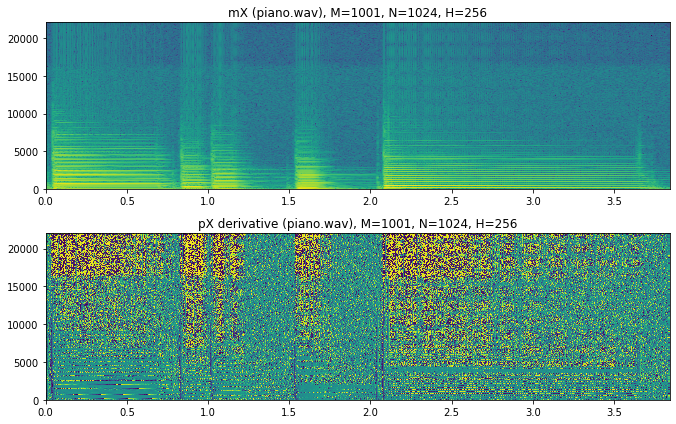

In [11]:


def stftAnal(x, w, N, H):
    """
    Analysis of a sound using the short-time Fourier transform
    x: input array sound, w: analysis window, N: FFT size, H: hop size
    returns xmX, xpX: magnitude and phase spectra
    """
    if (H <= 0):                                   # raise error if hop size 0 or negative
        raise ValueError("Hop size (H) smaller or equal to 0")
        
    M = w.size                                      # size of analysis window
    hM1 = (M+1)//2                                  # half analysis window size by rounding
    hM2 = M//2                                      # half analysis window size by floor
    x = np.append(np.zeros(hM2),x)                  # add zeros at beginning to center first window at sample 0
    x = np.append(x,np.zeros(hM2))                  # add zeros at the end to analyze last sample
    pin = hM1                                       # initialize sound pointer in middle of analysis window       
    pend = x.size-hM1                               # last sample to start a frame
    w = w / sum(w)                                  # normalize analysis window
    while pin<=pend:                                # while sound pointer is smaller than last sample      
        x1 = x[pin-hM1:pin+hM2]                     # select one frame of input sound
        mX, pX = dftAnal(x1, w, N)              # compute dft
        if pin == hM1:                              # if first frame create output arrays
            xmX = np.array([mX])
            xpX = np.array([pX])
        else:                                       # append output to existing array 
            xmX = np.vstack((xmX,np.array([mX])))
            xpX = np.vstack((xpX,np.array([pX])))
        pin += H                                    # advance sound pointer
    return xmX, xpX

(fs, x) = read('/Users/isabelledias/Downloads/sms-tools-master/sounds/piano.wav')
w = np.hamming(1001)
N = 1024
H = 256
mX, pX = stftAnal(x, w, N, H)

plt.figure(1, figsize=(9.5, 6))

plt.subplot(211)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)                             
binFreq = np.arange(N/2+1)*float(fs)/N                         
plt.pcolormesh(frmTime, binFreq, np.transpose(mX))
plt.title('mX (piano.wav), M=1001, N=1024, H=256')
plt.autoscale(tight=True)

plt.subplot(212)
numFrames = int(pX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)                             
binFreq = np.arange(N/2+1)*float(fs)/N                         
plt.pcolormesh(frmTime, binFreq, np.diff(np.transpose(pX),axis=0))
plt.title('pX derivative (piano.wav), M=1001, N=1024, H=256')
plt.autoscale(tight=True)

plt.tight_layout()
plt.savefig('spectrogram.png')
plt.show()

piano.wav, avec une fenêtre de Blackman,  𝑀=513, N=1024 et 𝐻=128


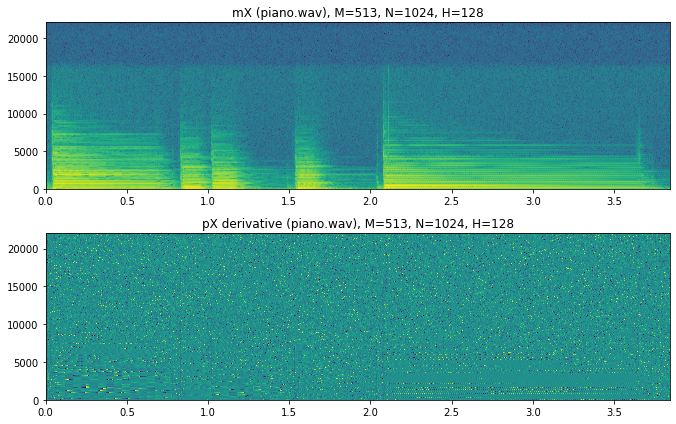

piano.wav, avec une fenêtre de Blackman,  𝑀=2047, N=4096 et 𝐻=128


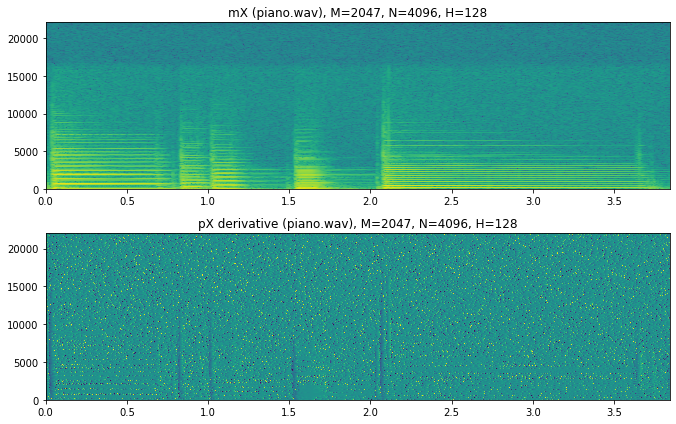

sax-phrase-short.wav, avec une fenêtre de Hamming,  𝑀=513, N=2048 et 𝐻=256


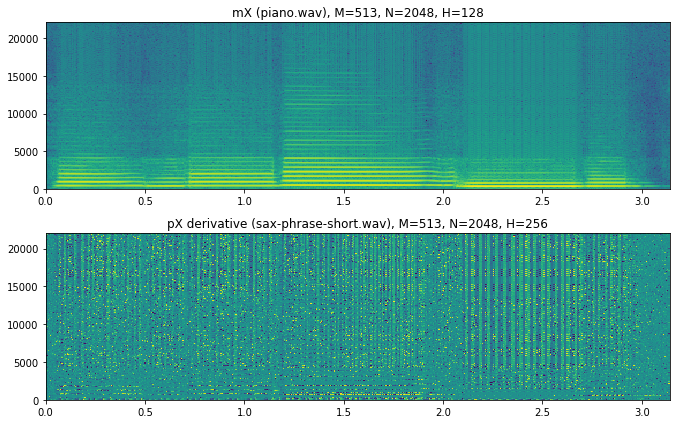

In [12]:
#cas 1 
w = np.blackman(513)
N = 1024
H = 128
mX, pX = stftAnal(x, w, N, H)
print('piano.wav, avec une fenêtre de Blackman,  𝑀=513, N=1024 et 𝐻=128')
plt.figure(1, figsize=(9.5, 6))

plt.subplot(211)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)                             
binFreq = np.arange(N/2+1)*float(fs)/N                         
plt.pcolormesh(frmTime, binFreq, np.transpose(mX))
plt.title('mX (piano.wav), M=513, N=1024, H=128')
plt.autoscale(tight=True)

plt.subplot(212)
numFrames = int(pX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)                             
binFreq = np.arange(N/2+1)*float(fs)/N                         
plt.pcolormesh(frmTime, binFreq, np.diff(np.transpose(pX),axis=0))
plt.title('pX derivative (piano.wav), M=513, N=1024, H=128')
plt.autoscale(tight=True)

plt.tight_layout()
plt.savefig('spectrogram.png')
plt.show()

#cas 2 
w = np.blackman(2047)
N = 4096
H = 128
mX, pX = stftAnal(x, w, N, H)
print('piano.wav, avec une fenêtre de Blackman,  𝑀=2047, N=4096 et 𝐻=128')
plt.figure(2, figsize=(9.5, 6))

plt.subplot(211)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)                             
binFreq = np.arange(N/2+1)*float(fs)/N                         
plt.pcolormesh(frmTime, binFreq, np.transpose(mX))
plt.title('mX (piano.wav), M=2047, N=4096, H=128')
plt.autoscale(tight=True)

plt.subplot(212)
numFrames = int(pX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)                             
binFreq = np.arange(N/2+1)*float(fs)/N                         
plt.pcolormesh(frmTime, binFreq, np.diff(np.transpose(pX),axis=0))
plt.title('pX derivative (piano.wav), M=2047, N=4096, H=128')
plt.autoscale(tight=True)

plt.tight_layout()
plt.savefig('spectrogram.png')
plt.show()


#cas 3 
(fs, x) = read('/Users/isabelledias/Downloads/sms-tools-master/sounds/sax-phrase-short.wav')
w = np.hamming(513)
N = 2048
H = 256
mX, pX = stftAnal(x, w, N, H)
print('sax-phrase-short.wav, avec une fenêtre de Hamming,  𝑀=513, N=2048 et 𝐻=256')
plt.figure(2, figsize=(9.5, 6))

plt.subplot(211)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)                             
binFreq = np.arange(N/2+1)*float(fs)/N                         
plt.pcolormesh(frmTime, binFreq, np.transpose(mX))
plt.title('mX (piano.wav), M=513, N=2048, H=128')
plt.autoscale(tight=True)

plt.subplot(212)
numFrames = int(pX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)                             
binFreq = np.arange(N/2+1)*float(fs)/N                         
plt.pcolormesh(frmTime, binFreq, np.diff(np.transpose(pX),axis=0))
plt.title('pX derivative (sax-phrase-short.wav), M=513, N=2048, H=256')
plt.autoscale(tight=True)

plt.tight_layout()
plt.savefig('spectrogram.png')
plt.show()

In [13]:


def computeEngEnv(inputFile, window, M, N, H):
    """
    Inputs:
            inputFile (string): input sound file (monophonic with sampling rate of 44100)
            window (string): analysis window type (choice of rectangular, triangular, hanning, 
                hamming, blackman, blackmanharris)
            M (integer): analysis window size (odd positive integer)
            N (integer): FFT size (power of 2, such that N > M)
            H (integer): hop size for the stft computation
    Output:
            The function should return a numpy array engEnv with shape Kx2, K = Number of frames
            containing energy envelop of the signal in decibles (dB) scale
            engEnv[:,0]: Energy envelope in band 0 < f < 3000 Hz (in dB)
            engEnv[:,1]: Energy envelope in band 3000 < f < 10000 Hz (in dB)
    """
    
    ### your code here 
    
    (fs, x) = read(inputFile)
    border_bin = int(np.ceil(float(3000) * N / fs))
    max_bin = int(np.ceil(float(10000) * N / fs))
    w = get_window(window, M)
    
    mX, pX = stftAnal(x, w, N, H)
    low = np.transpose(np.transpose(mX)[1:border_bin]) #point minumum
    high = np.transpose(np.transpose(mX)[border_bin:max_bin]) #point maximum
    
    e_low = 10 * np.log10(np.sum((10 ** (low / 20)) ** 2, axis=1)) #energie plus bas
    e_high = 10 * np.log10(np.sum((10 ** (high / 20)) ** 2, axis=1)) #energie plus haut
    
    envs = np.append([e_low], [e_high], axis=0) #envelope
    envs = np.transpose(envs)
    
    # graph en Db 
    plt.figure(1, figsize=(9.5, 6))

    plt.subplot(211)
    numFrames = mX.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    binFreq = np.arange(mX.shape[1])*float(fs)/N
    plt.pcolormesh(frmTime, binFreq, np.transpose(mX))
    plt.title('mX ({0}), M={1}, N={2}, H={3}'.format(inputFile, M, N, H))
    plt.autoscale(tight=True)
    
    plt.subplot(212)
    plt.plot(frmTime, e_low, color="blue", label="row")
    plt.plot(frmTime, e_high, color="red", label="high")
    plt.title('Energie en dB')
    plt.autoscale(tight=True)

    plt.tight_layout()
    plt.show()
    
    return envs

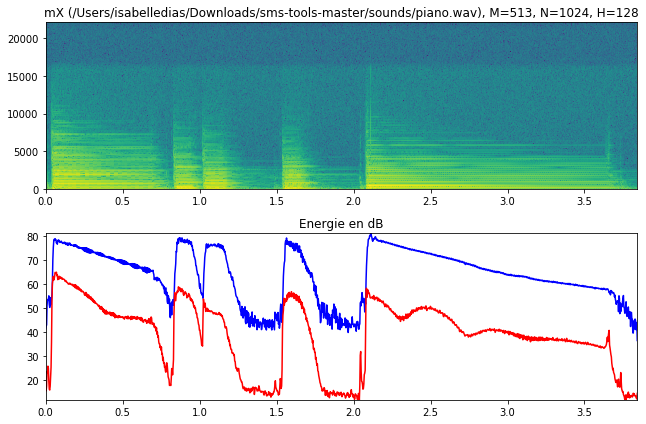

[[41.28743528 21.16269227]
 [42.51453198 15.46077765]
 [42.86338728 17.41006344]
 ...
 [43.92302679 12.45928054]
 [43.35564847 12.09677304]
 [36.43627022 14.423316  ]]


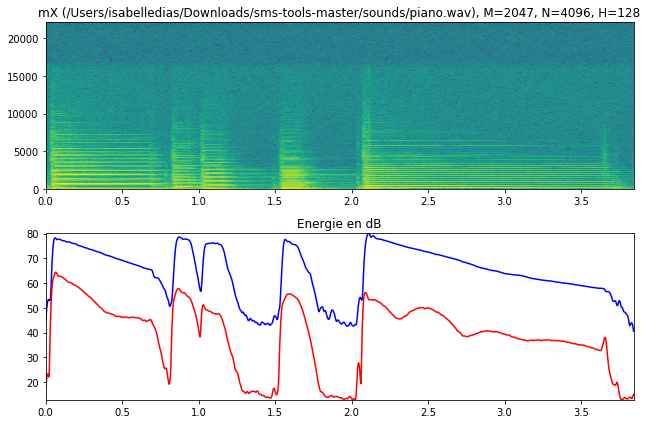

[[43.69611024 17.96574693]
 [46.6576018  19.59942393]
 [49.0760257  21.07511406]
 ...
 [42.97219777 13.85315356]
 [42.01770226 14.51633871]
 [40.55829553 14.97221901]]


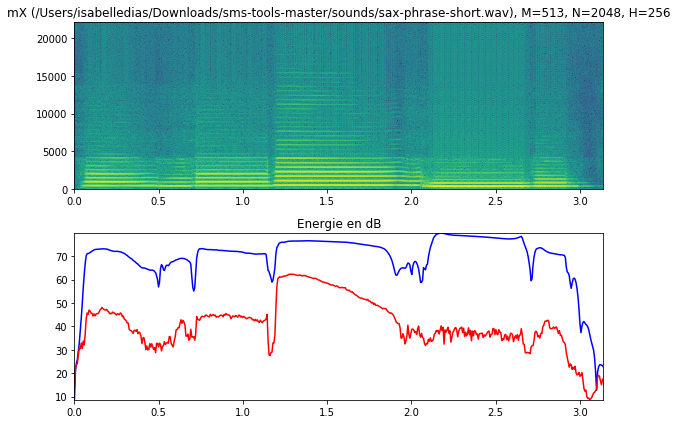

[[ 8.81771244 14.65167177]
 [20.55786735 22.78677551]
 [24.27116955 23.58110962]
 ...
 [23.33995519 15.02286282]
 [23.29771285 17.44095505]
 [22.55931091 16.69149017]]


In [14]:
x=computeEngEnv('/Users/isabelledias/Downloads/sms-tools-master/sounds/piano.wav', 'blackman', 513, 1024, 128)
print(x)
x=computeEngEnv('/Users/isabelledias/Downloads/sms-tools-master/sounds/piano.wav', 'blackman', 2047, 4096, 128)
print(x)
x=computeEngEnv('/Users/isabelledias/Downloads/sms-tools-master/sounds/sax-phrase-short.wav', 'hamming', 513, 2048, 256)
print(x)

## Analyse de notes

L'ojbectif du petit exercices suivant est, à partir d'un fichier 'wav', de détecter le tempo d'une musique, la durée des notes afférentes (une noire à 180 bpm veut dire qu'il y a 180 noires par minutes, et donc qu'une noire dure 333 ms) et de déterminer la note.

Vous trouverez par exemple les fréquences des notes, avec la notation anglaise, sur : https://www.intmath.com/trigonometric-graphs/music.php

4 fichiers "tune1.wav" jusque "tune4.wav" vous sont fournis, et on vous demande de déterminer le tempo, les notes et la durée des notes (la durée des notes étant égale à la $(\mbox{durée d'une noire})^{2n}$, où $n$ peut être négatif ou positif, et $n$ vaut entre -3 et 3).  Vous ferez ce travail en utilisant la stft, voire la dft sur des morceaux.

Vous donnerez les paramètres que vous utilisez pour la stft, ainsi que le résultat (en quelque sorte la partition).  Notez qu'a certain moments, vous pouvez avoir plusieurs notes en même temps !


